# Exploring Air Quality Data

Exploring some air quality data, and methods for cutting it to shapefiles of principal urban areas (PUAs).

## Setup

In [50]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dask.dataframe as dd

import os
import sys
import glob

import shape_utils as shape

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Load Data

In [2]:
folders = glob.glob('/data/misc/covid-19/data_nc_daily/precip*')
filepaths = []
for folder in folders:
    filepaths.extend(glob.glob(os.path.join(folder, '*.nc')))
print(len(filepaths))

182


In [3]:
%%time
cubes = iris.load(filepaths)
    
print(cubes)

0: precipitation_flux / (kg m-2 s-1)   (time: 91; latitude: 1920; longitude: 2560)
1: precipitation_flux / (kg m-2 s-1)   (time: 91; latitude: 1920; longitude: 2560)
CPU times: user 11.9 s, sys: 591 ms, total: 12.5 s
Wall time: 2min 5s


In [4]:
uk_cubes = iris.cube.CubeList([cube.intersection(latitude=(48, 63), longitude=(-15, 5)) for cube in cubes])
print(uk_cubes)

0: precipitation_flux / (kg m-2 s-1)   (time: 91; latitude: 160; longitude: 143)
1: precipitation_flux / (kg m-2 s-1)   (time: 91; latitude: 160; longitude: 143)


In [5]:
CRS = uk_cubes[0].coord_system()
CRS

GeogCS(6371229.0)

In [7]:
cells = [cell for cell in cubes[0].coord('time').cells()]
cells[0]

Cell(point=real_datetime(2020, 1, 1, 11, 0), bound=(real_datetime(2019, 12, 31, 23, 0), real_datetime(2020, 1, 1, 23, 0)))

### Load shapefile

In [30]:
regions_shp = '/data/misc/covid-19/shapefiles/UK/UK_covid_reporting_regions.shx'
regions_reader = shpreader.Reader(regions_shp)

In [31]:
next(regions_reader.records())

<Record: <shapely.geometry.multipolygon.MultiPolygon object at 0x7f6613052cf8>, {'code': 'E06000001', 'name': 'Hartlepool', 'area': 96512310.8872846}, <fields>>

In [33]:
region_codes = [record.attributes['code'] for record in regions_reader.records()]

print(region_codes)

['E06000001', 'E06000002', 'E06000003', 'E06000004', 'E06000005', 'E06000006', 'E06000007', 'E06000008', 'E06000009', 'E06000010', 'E06000011', 'E06000012', 'E06000013', 'E06000014', 'E06000015', 'E06000016', 'E06000017', 'E06000018', 'E06000019', 'E06000020', 'E06000021', 'E06000022', 'E06000023', 'E06000024', 'E06000025', 'E06000026', 'E06000027', 'E06000030', 'E06000031', 'E06000032', 'E06000033', 'E06000034', 'E06000035', 'E06000036', 'E06000037', 'E06000038', 'E06000039', 'E06000040', 'E06000041', 'E06000042', 'E06000043', 'E06000044', 'E06000045', 'E06000046', 'E06000047', 'E06000049', 'E06000050', 'E06000051', 'E06000052', 'E06000053', 'E06000054', 'E06000055', 'E08000009', 'E06000056', 'E06000057', 'E06000058', 'E06000059', 'E08000001', 'E08000002', 'E08000003', 'E08000004', 'E08000005', 'E08000006', 'E08000007', 'E08000008', 'E08000010', 'E08000011', 'E08000012', 'E08000013', 'E08000014', 'E08000015', 'E08000016', 'E08000017', 'E08000018', 'E08000019', 'E08000021', 'E08000022'

In [34]:
def get_region_record(target, shapefile=regions_reader, attribute='code'):
    '''
    Get the geometries for the specified location.
    
    '''
    result = None
    for record in shapefile.records():
        location = record.attributes[attribute]
        if location == target:
            result = record
            break
    if result is None:
        emsg = 'Could not find region with name "{}".'
        raise ValueError(emsg.format(target))
    return result

In [43]:
from random import randint
def rand_code(codes=region_codes): 
    i = randint(0, len(codes))
    return codes[i]

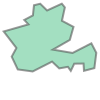

In [47]:
get_region_record(rand_code()).geometry

## Work out which files have been written, and which still have to be

In [ ]:
csvs = glob.glob('/data/misc/covid-19/uk_data_precip/*.csv')

In [ ]:
df = dd.read_csv(csvs)
df.compute()

In [ ]:
written = list(df['region'].unique().compute())
written

In [ ]:
len(written)

In [ ]:
unwritten = list(set(region_names).difference(set(written)))
len(unwritten)

In [ ]:
unwritten

In [ ]:
len(unwritten)+len(written)

## Create a pipeline

In [27]:
def parse_data_name(cube):
    name = cube.name()
    method = cube.cell_methods[1].method.replace('imum', '')
    units = cube.units
    
    if name == 'm01s01i202':
        name = 'short_wave_radiation'
        units = 'W/m2'
    
    return f'{name}_{method} ({units})'

In [55]:
col0 = ['region_code', 'region_name', 'date']
col1 = [parse_data_name(cube) for cube in uk_cubes]

In [56]:
COL_ORDER = tuple(col0 + sorted([c for c in col1 if c not in col0]))
COL_ORDER

('region_code',
 'region_name',
 'date',
 'precipitation_flux_max (kg m-2 s-1)',
 'precipitation_flux_mean (kg m-2 s-1)')

In [39]:
def extract(location, cubes=uk_cubes, **kwargs):
    region = get_region_record(location, **kwargs)
    cutter = shape.Shape(region.geometry, region.attributes, coord_system=CRS)
    cut_cubes = cutter.extract_subcubes(cubes)
#     cubes_col = [cube.collapsed(['latitude','longitude'], iris.analysis.MEAN) for cube in cut_cubes]
    return cut_cubes

In [57]:
def extract_collapse_df(location, cubes=uk_cubes, **kwargs):
    region = get_region_record(location, **kwargs)
    cutter = shape.Shape(region.geometry, region.attributes, coord_system=CRS)
    cut_cubes = cutter.extract_subcubes(cubes)
    cubes_col = [cube.collapsed(['latitude','longitude'], iris.analysis.MEAN) for cube in cut_cubes]
    time = cubes_col[0].coord('time')
    length = len(time.points)
    data = {'region_code': [location]*length,
            'region_name': [region.attributes['name']]*length,
            'date': [cell.point.date() for cell in time.cells()]}
    data.update({parse_data_name(cube): cube.data for cube in cubes_col})
    
    df = pd.DataFrame(data, columns=COL_ORDER)

    return df

In [58]:
%%time
df_ex = extract_collapse_df(rand_code())
df_ex

CPU times: user 2.73 s, sys: 2.85 s, total: 5.58 s
Wall time: 3.06 s


,region_code,region_name,date,precipitation_flux_max (kg m-2 s-1),precipitation_flux_mean (kg m-2 s-1)
0,E09000006,Bromley,2020-01-01,0.000006,1.139111e-06
1,E09000006,Bromley,2020-01-02,0.000053,1.155006e-05
2,E09000006,Bromley,2020-01-03,0.000170,3.025267e-05
3,E09000006,Bromley,2020-01-04,0.000007,3.973643e-07
4,E09000006,Bromley,2020-01-05,0.000025,2.119276e-06
...,...,...,...,...,...
86,E09000006,Bromley,2020-03-27,0.000000,0.000000e+00
87,E09000006,Bromley,2020-03-28,0.000025,1.854367e-06
88,E09000006,Bromley,2020-03-29,0.000050,5.271700e-06
89,E09000006,Bromley,2020-03-30,0.000030,4.503462e-06


## Save dataframe to csv for each location

In [59]:
print(uk_cubes)

0: precipitation_flux / (kg m-2 s-1)   (time: 91; latitude: 160; longitude: 143)
1: precipitation_flux / (kg m-2 s-1)   (time: 91; latitude: 160; longitude: 143)


In [62]:
unwritten = region_codes
len(unwritten)

183

In [65]:
%%time
dfs = []
start = 3
stop = len(region_codes)
for location in unwritten[start:]:
    try:
        df = extract_collapse_df(location)
        name = df['region_name'][0].replace(' ', '_').replace(',','').replace('.','')
        df.to_csv(f'/data/misc/covid-19/uk_data_precip/uk_{location}_{name}_daily_precipdata_2020jan-mar.csv', index=False)
        print(f'  [{location}] {name}: Success')
    except Exception as e:
        print(f'x [{location}] {name}: Error \n  x  {e}')

  [E06000004] Stockton-on-Tees: Success
  [E06000005] Darlington: Success
  [E06000006] Halton: Success
  [E06000007] Warrington: Success
  [E06000008] Blackburn_with_Darwen: Success
  [E06000009] Blackpool: Success
  [E06000010] Kingston_upon_Hull_City_of: Success
  [E06000011] East_Riding_of_Yorkshire: Success
  [E06000012] North_East_Lincolnshire: Success
  [E06000013] North_Lincolnshire: Success
  [E06000014] York: Success
  [E06000015] Derby: Success
  [E06000016] Leicester: Success
  [E06000017] Rutland: Success
  [E06000018] Nottingham: Success
  [E06000019] Herefordshire_County_of: Success
  [E06000020] Telford_and_Wrekin: Success
  [E06000021] Stoke-on-Trent: Success
  [E06000022] Bath_and_North_East_Somerset: Success
  [E06000023] Bristol_City_of: Success
  [E06000024] North_Somerset: Success
  [E06000025] South_Gloucestershire: Success
  [E06000026] Plymouth: Success
  [E06000027] Torbay: Success
  [E06000030] Swindon: Success
  [E06000031] Peterborough: Success
  [E06000032

**NB: **

## Open all the written CSVs and concatenate them into a mega DataFrame

In [66]:
csvs = glob.glob('/data/misc/covid-19/uk_data_precip/*.csv')
len(csvs)

181

In [67]:
%%time
Mdf = pd.concat([pd.read_csv(csv) for csv in csvs], ignore_index=True)
Mdf

CPU times: user 483 ms, sys: 0 ns, total: 483 ms
Wall time: 638 ms


,region_code,region_name,date,precipitation_flux_max (kg m-2 s-1),precipitation_flux_mean (kg m-2 s-1)
0,E06000033,Southend-on-Sea,2020-01-01,0.000010,1.629194e-06
1,E06000033,Southend-on-Sea,2020-01-02,0.000017,2.900759e-06
2,E06000033,Southend-on-Sea,2020-01-03,0.000149,2.388159e-05
3,E06000033,Southend-on-Sea,2020-01-04,0.000004,1.986822e-07
4,E06000033,Southend-on-Sea,2020-01-05,0.000019,1.708667e-06
...,...,...,...,...,...
16466,E06000003,Redcar and Cleveland,2020-03-27,0.000002,1.192093e-07
16467,E06000003,Redcar and Cleveland,2020-03-28,0.000063,8.761883e-06
16468,E06000003,Redcar and Cleveland,2020-03-29,0.000030,8.126100e-06
16469,E06000003,Redcar and Cleveland,2020-03-30,0.000037,4.529953e-06


In [68]:
def df_hists(df):
    for col in df:
        plt.hist(df[col])
        plt.title(f'{col}')
        plt.show()

In [69]:
Mdf[Mdf.columns[3:]]

,precipitation_flux_max (kg m-2 s-1),precipitation_flux_mean (kg m-2 s-1)
0,0.000010,1.629194e-06
1,0.000017,2.900759e-06
2,0.000149,2.388159e-05
3,0.000004,1.986822e-07
4,0.000019,1.708667e-06
...,...,...
16466,0.000002,1.192093e-07
16467,0.000063,8.761883e-06
16468,0.000030,8.126100e-06
16469,0.000037,4.529953e-06


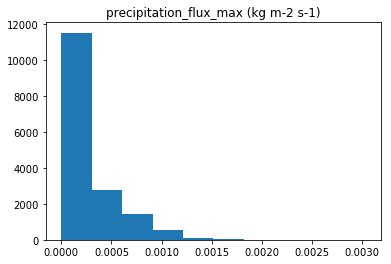

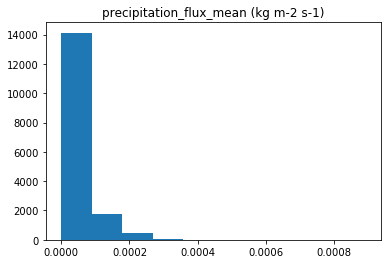

CPU times: user 4.07 s, sys: 0 ns, total: 4.07 s
Wall time: 322 ms


In [70]:
%%time
df_hists(Mdf[Mdf.columns[3:]])

**Data looks sensible, I think we have successfully made a mega dataframe!**

## Let's now write that out to a file

In [71]:
%%time
Mdf.to_csv(f'/data/misc/covid-19/uk_data_precip/uk_daily_precipdata_2020jan-mar_v01.csv', index=False)

CPU times: user 87.8 ms, sys: 0 ns, total: 87.8 ms
Wall time: 184 ms


## Now we need to load the other mega dataframe and merge it with the precip dataframe we just made

In [73]:
fulldf = pd.read_csv('/data/misc/covid-19/uk_data/UKregions_daily_meteodata_2020jan-mar_v02.csv')
fulldf

,region_code,region_name,date,air_temperature_max (K),air_temperature_mean (K),air_temperature_min (K),short_wave_radiation_max (W/m2),short_wave_radiation_mean (W/m2),specific_humidity_max (1),specific_humidity_mean (1),specific_humidity_min (1)
0,W11000028,Aneurin Bevan University Health Board,2020-01-01,280.32380,278.65225,277.14670,107.931854,15.872722,0.006246,0.005460,0.004842
1,W11000028,Aneurin Bevan University Health Board,2020-01-02,282.86154,280.63858,278.07336,80.705290,13.096335,0.007256,0.006177,0.005154
2,W11000028,Aneurin Bevan University Health Board,2020-01-03,282.58160,279.85855,276.90192,161.631520,28.314524,0.007141,0.005413,0.004333
3,W11000028,Aneurin Bevan University Health Board,2020-01-04,280.16450,278.74075,276.34897,98.807290,16.487267,0.005690,0.005051,0.004306
4,W11000028,Aneurin Bevan University Health Board,2020-01-05,280.77258,279.83930,279.09723,95.183590,14.714047,0.005961,0.005630,0.005310
...,...,...,...,...,...,...,...,...,...,...,...
16466,E06000014,York,2020-03-27,283.71700,277.96400,272.95660,544.651060,169.295930,0.004395,0.003835,0.003282
16467,E06000014,York,2020-03-28,282.71180,278.98505,276.44965,464.074650,108.072990,0.004883,0.004111,0.003092
16468,E06000014,York,2020-03-29,279.44965,276.99610,274.28647,357.055540,89.059105,0.003418,0.003034,0.002713
16469,E06000014,York,2020-03-30,281.85416,278.98300,275.42535,335.862850,78.952770,0.005046,0.004357,0.003201


### To ensure the dataframes merge exactly on their common rows, let's pass all their common columns to `merge()`, which we defined in `col0` earlier

In [74]:
col0

['region_code', 'region_name', 'date']

In [75]:
%%time
mergedf = fulldf.merge(Mdf, how='left', on=col0)
mergedf

CPU times: user 16.3 ms, sys: 0 ns, total: 16.3 ms
Wall time: 15.1 ms


,region_code,region_name,date,air_temperature_max (K),air_temperature_mean (K),air_temperature_min (K),short_wave_radiation_max (W/m2),short_wave_radiation_mean (W/m2),specific_humidity_max (1),specific_humidity_mean (1),specific_humidity_min (1),precipitation_flux_max (kg m-2 s-1),precipitation_flux_mean (kg m-2 s-1)
0,W11000028,Aneurin Bevan University Health Board,2020-01-01,280.32380,278.65225,277.14670,107.931854,15.872722,0.006246,0.005460,0.004842,0.000045,1.013279e-05
1,W11000028,Aneurin Bevan University Health Board,2020-01-02,282.86154,280.63858,278.07336,80.705290,13.096335,0.007256,0.006177,0.005154,0.000182,3.007606e-05
2,W11000028,Aneurin Bevan University Health Board,2020-01-03,282.58160,279.85855,276.90192,161.631520,28.314524,0.007141,0.005413,0.004333,0.000333,4.182922e-05
3,W11000028,Aneurin Bevan University Health Board,2020-01-04,280.16450,278.74075,276.34897,98.807290,16.487267,0.005690,0.005051,0.004306,0.000040,6.777269e-06
4,W11000028,Aneurin Bevan University Health Board,2020-01-05,280.77258,279.83930,279.09723,95.183590,14.714047,0.005961,0.005630,0.005310,0.000054,1.660541e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16466,E06000014,York,2020-03-27,283.71700,277.96400,272.95660,544.651060,169.295930,0.004395,0.003835,0.003282,0.000000,0.000000e+00
16467,E06000014,York,2020-03-28,282.71180,278.98505,276.44965,464.074650,108.072990,0.004883,0.004111,0.003092,0.000003,1.942670e-07
16468,E06000014,York,2020-03-29,279.44965,276.99610,274.28647,357.055540,89.059105,0.003418,0.003034,0.002713,0.000002,8.830318e-08
16469,E06000014,York,2020-03-30,281.85416,278.98300,275.42535,335.862850,78.952770,0.005046,0.004357,0.003201,0.000011,1.236244e-06


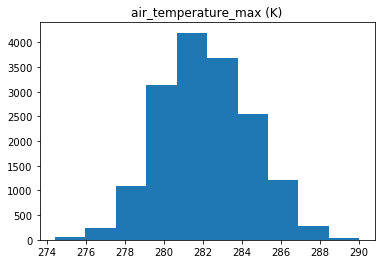

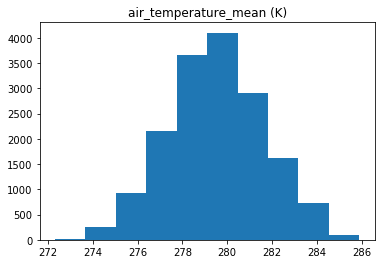

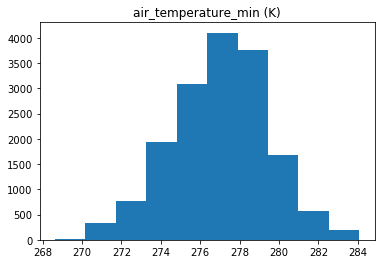

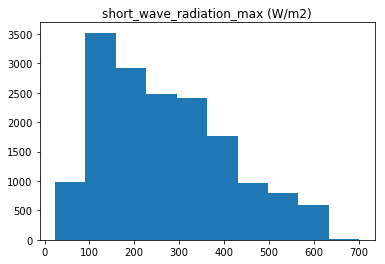

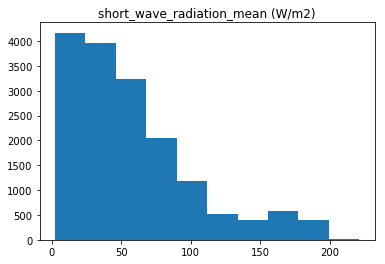

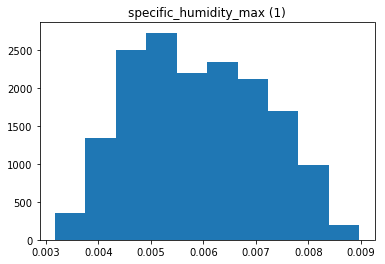

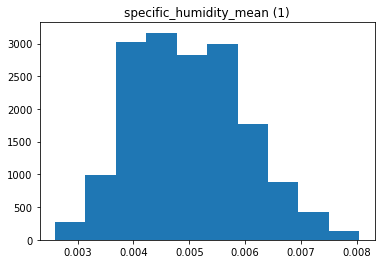

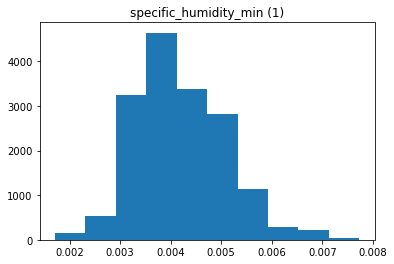

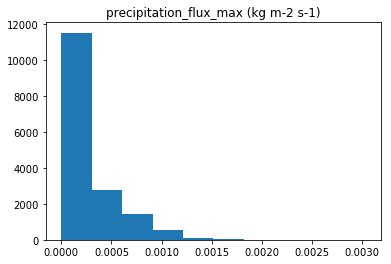

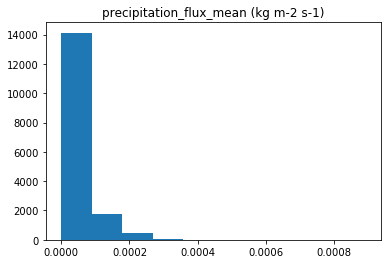

CPU times: user 19.4 s, sys: 0 ns, total: 19.4 s
Wall time: 1.42 s


In [77]:
%%time
df_hists(mergedf[mergedf.columns[3:]])

**Success! The data looks good**

### Now let's check that all the values in `Mdf` and `mergedf` are the same for the columns we added

First we need to get `Mdf` on the same indices as `mergdf`

In [79]:
mdfsort = Mdf.sort_values(by=col0).reset_index(drop=True)
fulldfsort = fulldf.sort_values(by=col0).reset_index(drop=True)
mergedfsort = mergedf.sort_values(by=col0).reset_index(drop=True)

In [80]:
for col in mdfsort:
    print(mergedfsort[col].all() == mdfsort[col].all())

True
True
True
True
True


#### And for good measure let's check it with `fulldf`

In [81]:
for col in fulldf:
    print(mergedfsort[col].all() == fulldfsort[col].all())

True
True
True
True
True
True
True
True
True
True
True


In [82]:
mergedfsort

,region_code,region_name,date,air_temperature_max (K),air_temperature_mean (K),air_temperature_min (K),short_wave_radiation_max (W/m2),short_wave_radiation_mean (W/m2),specific_humidity_max (1),specific_humidity_mean (1),specific_humidity_min (1),precipitation_flux_max (kg m-2 s-1),precipitation_flux_mean (kg m-2 s-1)
0,E06000001,Hartlepool,2020-01-01,279.23438,277.24237,275.92578,147.90234,19.283041,0.004944,0.004707,0.004456,0.000010,1.351039e-06
1,E06000001,Hartlepool,2020-01-02,283.07812,280.12906,277.55078,117.69141,18.449871,0.006592,0.005501,0.004761,0.000000,0.000000e+00
2,E06000001,Hartlepool,2020-01-03,282.79688,279.74660,277.96875,154.80078,22.860188,0.006592,0.004878,0.004150,0.000041,2.861023e-06
3,E06000001,Hartlepool,2020-01-04,282.01562,280.29282,279.26953,153.47656,23.798340,0.005432,0.005099,0.004700,0.000002,7.947286e-08
4,E06000001,Hartlepool,2020-01-05,282.67578,281.60907,280.41406,122.05469,18.692709,0.006348,0.005755,0.005432,0.000006,3.973643e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16466,W11000031,Swansea Bay University Health Board,2020-03-27,284.41016,279.68423,274.68164,608.30730,189.089130,0.004496,0.003690,0.002869,0.000000,0.000000e+00
16467,W11000031,Swansea Bay University Health Board,2020-03-28,284.02084,280.05783,276.41602,568.18945,166.634960,0.004517,0.003757,0.003052,0.000001,7.947286e-08
16468,W11000031,Swansea Bay University Health Board,2020-03-29,280.81186,277.91107,275.54947,554.54690,136.794430,0.003326,0.002971,0.002736,0.000002,1.788139e-07
16469,W11000031,Swansea Bay University Health Board,2020-03-30,282.18686,278.47250,273.73697,458.61133,115.668330,0.004496,0.003804,0.002930,0.000002,1.986821e-07


## The data has lined up well, so let's save out the merged dataframe

In [86]:
# rename the region code to output code
mergedfsort.rename(columns={'region_code': 'output_code'}, inplace=True)
mergedfsort

,output_code,region_name,date,air_temperature_max (K),air_temperature_mean (K),air_temperature_min (K),short_wave_radiation_max (W/m2),short_wave_radiation_mean (W/m2),specific_humidity_max (1),specific_humidity_mean (1),specific_humidity_min (1),precipitation_flux_max (kg m-2 s-1),precipitation_flux_mean (kg m-2 s-1)
0,E06000001,Hartlepool,2020-01-01,279.23438,277.24237,275.92578,147.90234,19.283041,0.004944,0.004707,0.004456,0.000010,1.351039e-06
1,E06000001,Hartlepool,2020-01-02,283.07812,280.12906,277.55078,117.69141,18.449871,0.006592,0.005501,0.004761,0.000000,0.000000e+00
2,E06000001,Hartlepool,2020-01-03,282.79688,279.74660,277.96875,154.80078,22.860188,0.006592,0.004878,0.004150,0.000041,2.861023e-06
3,E06000001,Hartlepool,2020-01-04,282.01562,280.29282,279.26953,153.47656,23.798340,0.005432,0.005099,0.004700,0.000002,7.947286e-08
4,E06000001,Hartlepool,2020-01-05,282.67578,281.60907,280.41406,122.05469,18.692709,0.006348,0.005755,0.005432,0.000006,3.973643e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16466,W11000031,Swansea Bay University Health Board,2020-03-27,284.41016,279.68423,274.68164,608.30730,189.089130,0.004496,0.003690,0.002869,0.000000,0.000000e+00
16467,W11000031,Swansea Bay University Health Board,2020-03-28,284.02084,280.05783,276.41602,568.18945,166.634960,0.004517,0.003757,0.003052,0.000001,7.947286e-08
16468,W11000031,Swansea Bay University Health Board,2020-03-29,280.81186,277.91107,275.54947,554.54690,136.794430,0.003326,0.002971,0.002736,0.000002,1.788139e-07
16469,W11000031,Swansea Bay University Health Board,2020-03-30,282.18686,278.47250,273.73697,458.61133,115.668330,0.004496,0.003804,0.002930,0.000002,1.986821e-07


In [87]:
%%time
mergedfsort.to_csv('/data/misc/covid-19/uk_daily_meteodata_2020jan-mar_v03.csv', index=False)

CPU times: user 278 ms, sys: 0 ns, total: 278 ms
Wall time: 449 ms


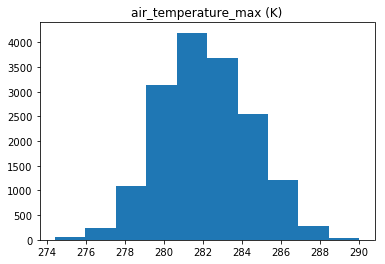

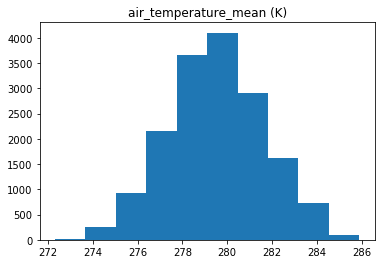

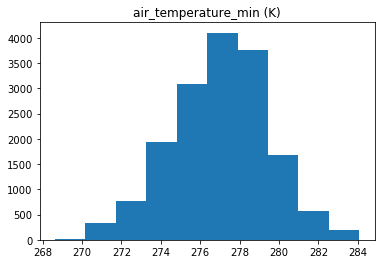

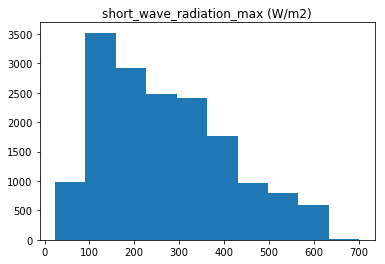

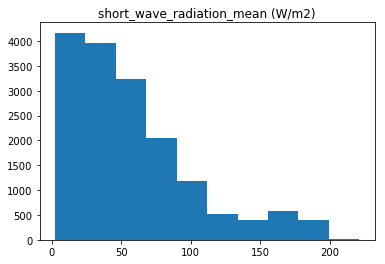

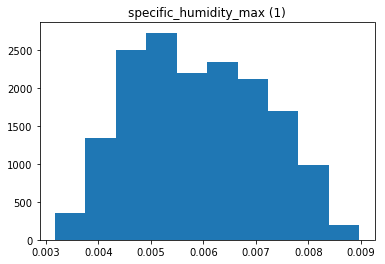

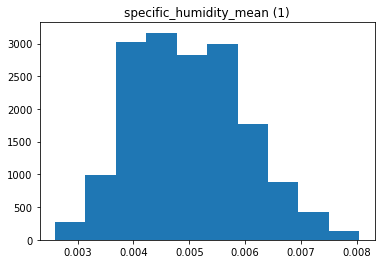

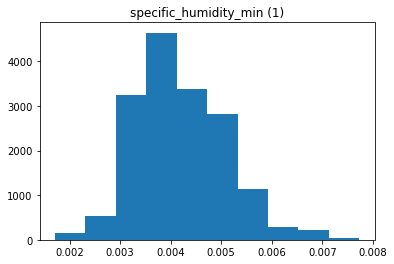

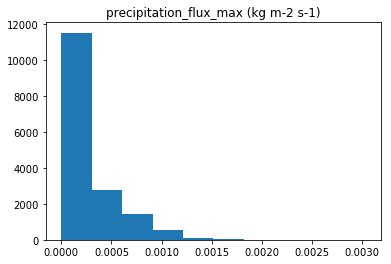

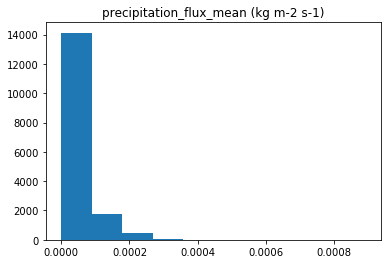

CPU times: user 17.1 s, sys: 0 ns, total: 17.1 s
Wall time: 1.3 s


In [84]:
%%time
mdf = pd.read_csv('/data/misc/covid-19/uk_daily_meteodata_2020jan-mar_v03.csv')
df_hists(mdf[mdf.columns[3:]])